In [1]:
import pandas as pd
train = pd.read_pickle("./data/train.pickle")
test = pd.read_pickle("./data/test.pickle")

In [2]:
from sklearn.utils import resample

train_majority = train[train.fraudLabel==0]
train_minority = train[train.fraudLabel==1]

# Upsample minority class
train_minority_upsampled = resample(train_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=train_majority.shape[0],  # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
train_upsampled = pd.concat([train_majority, train_minority_upsampled])

# Show new class counts
train_upsampled.fraudLabel.value_counts()

1    21036
0    21036
Name: fraudLabel, dtype: int64

In [3]:
X_train = train_upsampled[train_upsampled.columns[1:]]
y_train = train_upsampled["fraudLabel"]
X_test = test[test.columns[1:]]
y_test = test["fraudLabel"]

In [4]:
from sklearn.linear_model import LogisticRegression
logreg_up = LogisticRegression()
logreg_up.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [5]:
from sklearn import metrics
test_scores = logreg_up.predict_proba(X_test)
fpr_reg_up, tpr_reg_up, _ = metrics.roc_curve(y_test, test_scores[:,1])
auc_reg_up = metrics.auc(fpr_reg_up, tpr_reg_up)

In [6]:
predictions = pd.read_csv("./data/predictions.csv")
fpr_reg, tpr_reg, _ = metrics.roc_curve(predictions["label"], predictions["predReg"])
auc_reg = metrics.auc(fpr_reg, tpr_reg)
fpr_gbt, tpr_gbt, _ = metrics.roc_curve(predictions["label"], predictions["predGbt"])
auc_gbt = metrics.auc(fpr_gbt, tpr_gbt)

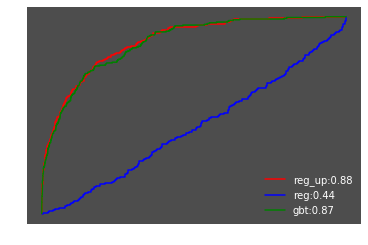

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr_reg_up, tpr_reg_up, color = 'red', label = "reg_up:{:.2f}".format(auc_reg_up))
plt.plot(fpr_reg, tpr_reg, color = 'blue', label = "reg:{:.2f}".format(auc_reg))
plt.plot(fpr_gbt, tpr_gbt, color = 'green', label = "gbt:{:.2f}".format(auc_gbt))
plt.legend()
plt.grid()
plt.show()

In [8]:
# save predictions of upsampled model
predictions['predReg_up'] = test_scores[:,1]
predictions.to_csv("./data/predictions_2.csv", index=False)

### Save predictions on train data for probCalib

In [9]:
# save predictions to csvb
df = pd.read_csv("./data/predictions_train.csv")
df["predReg_up"] = logreg_up.predict_proba(train[train.columns[1:]])[:,1]
df.to_csv("./data/predictions_train_2.csv", index=False)

# CALIBRATION STEP

Create sorted pred and y df

In [32]:
train_scores = logreg_up.predict_proba(X_train)
df_sort = pd.DataFrame({'pred':train_scores[:,1], 'y':y_train}).reset_index(drop=1)
df_sort = df_sort.sort_values(by='pred')
df_sort.head()
df_sort.tail()
#gbt_sort.dtypes
#pd.DataFrame(train_scores_gbt)

,pred,y
21798,0.999584,1
27743,0.999584,1
41923,0.999584,1
35591,0.999584,1
38463,0.999584,1


In [33]:
def split_df(df, chunkSize = 100): 
    listOfDf = list()
    numberChunks = len(df) // chunkSize + 1
    for i in range(numberChunks):
        listOfDf.append(df[i*chunkSize:(i+1)*chunkSize])
    return listOfDf

In [55]:
bsize = 500
buckets = split_df(df_sort, bsize)

In [56]:
print('DF length:',len(df_sort))
print('Number buckets',len(buckets))

DF length: 42072
Number buckets 85


In [57]:
cutoff = 0.5
rows = list()
for i,buck in enumerate(buckets[0:-1]):
    #print(buck)
    predicted_prob = np.mean(buck['pred'])
    real_prob = sum(buck['y'])/bsize
    rows.append([predicted_prob, real_prob])
    #print(i,predicted_prob, real_prob)
    #sum(buck['pred'])
    #print(len(buck['pred']))
    #raise

In [59]:
calibration = pd.DataFrame(rows, columns = ['predicted','real'])
##calibration.head(100)
calibration
calibration.tail()

,predicted,real
0,0.004537,0.000
1,0.012269,0.000
2,0.020605,0.000
3,0.028999,0.000
4,0.037456,0.000
5,0.047870,0.000
6,0.058137,0.050
7,0.069782,0.000
8,0.080686,0.208
9,0.090465,0.068


In [60]:
def calc_brier(cal):
    sub = cal['predicted'] - cal['real']
    bscore = sum(sub**2)/len(sub)
    return bscore
    #raise
calc_brier(calibration)

0.005173353558810899

In [61]:
def plot_calibration(calibration):
    fig = plt.figure(figsize=[10,10])
    #calibration.plot(x='real', y='predicted', style='bo',figsize=[10,10])
    plt.scatter(x=calibration['real'],y=calibration['predicted'])
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('Real')
    plt.ylabel('Pred')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

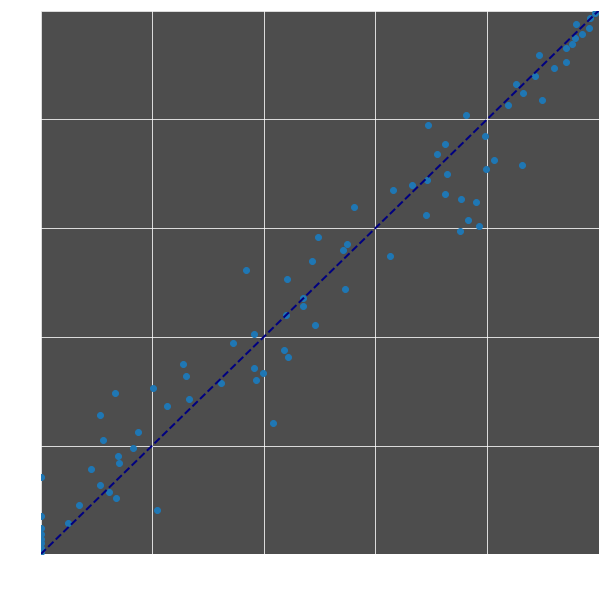

In [62]:
plot_calibration(calibration)

In [44]:
#!(imagename.png "Title")

/bin/sh: 1: imagename.png: not found


In [95]:
def calibration_map(cal, data):
    print('Calibration:',cal.shape)
    print(cal.head(5))
    print()
    print('Data:',data.shape)
    print(data.head())
    print()
    for index, row in data.head().iterrows():
        pred=row.values
        print(pred)
    #for row in data.head():
    #    print(row)
    raise


In [96]:
train_scores = logreg_up.predict_proba(X_train)

tr_vals = pd.DataFrame({'pred':train_scores[:,1]}).reset_index(drop=1)
#df_sort = df_sort.sort_values(by='pred')
#df_sort.head()
#df_sort.tail()

calibration_map(calibration,tr_vals)

Calibration: (84, 2)
   predicted  real
0   0.004537   0.0
1   0.012269   0.0
2   0.020605   0.0
3   0.028999   0.0
4   0.037456   0.0

Data: (42072, 1)
       pred
0  0.791735
1  0.053794
2  0.150455
3  0.407240
4  0.794466

[0.79173459]
[0.05379407]
[0.15045464]
[0.40723988]
[0.79446604]


RuntimeError: No active exception to reraise